# Evaluation of the ResNet-50 model

## Import libraries

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from scivision.io import load_pretrained_model, load_dataset

## Load hold-out (test) dataset

In [6]:
cat = load_dataset('https://github.com/alan-turing-institute/plankton-dsg-challenge')

ds_all = cat.plankton_multiple().to_dask()
labels_holdout = cat.labels_holdout().read()

labels_holdout_dedup = xr.Dataset.from_dataframe(
    labels_holdout
    .drop_duplicates(subset=["filename"])
    .set_index("filename")
    .sort_index()
)

ds_holdout_labelled = (
    ds_all
    .swap_dims({"concat_dim": "filename"})
    .merge(labels_holdout_dedup, join="inner")
    .swap_dims({"filename": "concat_dim"})
)

In [7]:
ds_holdout_labelled = ds_holdout_labelled.assign(
    image_width = ds_holdout_labelled['EXIF Image ImageWidth'].to_pandas().apply(lambda x: x.values[0]),
    image_length = ds_holdout_labelled['EXIF Image ImageLength'].to_pandas().apply(lambda x: x.values[0])
)

In [8]:
print(ds_holdout_labelled)

<xarray.Dataset>
Dimensions:                               (channel: 3, concat_dim: 5682, x: 1040, y: 832)
Coordinates:
    filename                              (concat_dim) object 'Pia1.2016-10-0...
  * concat_dim                            (concat_dim) int64 18 56 ... 58732
  * y                                     (y) int64 0 1 2 3 ... 828 829 830 831
  * x                                     (x) int64 0 1 2 3 ... 1037 1038 1039
  * channel                               (channel) int64 0 1 2
Data variables: (12/29)
    raster                                (concat_dim, y, x, channel) uint8 dask.array<chunksize=(1, 832, 1040, 3), meta=np.ndarray>
    EXIF Image ImageWidth                 (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image ImageLength                (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image BitsPerSample              (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image Compressi

## Load pretrained model

In [1]:
# run if changes are made in https://github.com/acocac/scivision-plankton-models then restart the kernel
#!pip -q uninstall -y scivision_plankton_models 

In [4]:
# Load model
scivision_yml = 'https://github.com/acocac/scivision-plankton-models/.scivision-config-resnet50_label3.yaml'
model = load_pretrained_model(scivision_yml, allow_install=True)

In [5]:
model

scivision.PretrainedModel( 
  module='scivision_plankton_models', 
  model='resnet50_label3', 
  source='https://github.com/acocac/scivision-plankton-models' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

## Dataset and Dataloader

In [31]:
from scivision_plankton_models import PlanktonDataset
from torch.utils.data import DataLoader
import tqdm
import torch
import matplotlib.pyplot as plt

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [26]:
dataset = PlanktonDataset(ds_holdout_labelled)

batch_size=24

num_iterations = max(1, len(dataset) // batch_size)
print(num_iterations)

236


In [28]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

## Predict and visualise

In [29]:
nb_classes = 39

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (_, inputs) in enumerate(dataloader):
        inputs = inputs.to(device)
        outputs = model.predict(inputs)
        _, preds = torch.max(outputs, 1)
        break

/home/alejandro.cocacastro/.local/lib/python3.8/site-packages/scivision_plankton_models/model.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(image)


In [30]:
preds

tensor([21, 38, 38,  4, 13, 28, 38,  4, 13, 38, 21, 21, 21, 38, 29, 12, 21, 18,
        18, 28, 21,  4, 21, 21])

## Verify resize operation

  0%|          | 0/5682 [00:00<?, ?it/s]

5682


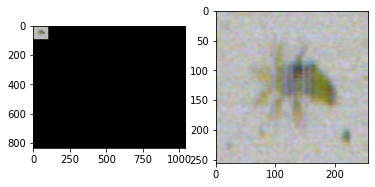

  0%|          | 0/5682 [00:00<?, ?it/s]


In [34]:
dataset = PlanktonDataset(ds_holdout_labelled)

batch_size=1

num_iterations = max(1, len(dataset) // batch_size)
print(num_iterations)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for i, (X_raw, X_pre) in enumerate(tqdm.tqdm(dataloader)):
    X_pre = X_pre[0,:,:,:]
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X_raw[0,:,:,:])
    plt.subplot(1, 2, 2)
    plt.imshow(X_pre.permute(1, 2, 0))
    plt.show()
    
    break